In [15]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Загрузка данных

In [16]:
data = pd.read_excel('data/data_ford_price.xlsx')

In [17]:
column_na = ['size','drive','weather']

## Предобработка данных

In [18]:
#Удалить пропуски
data.dropna(inplace = True)

In [19]:
data.reset_index()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5202 entries, 0 to 7016
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         5202 non-null   int64  
 1   year          5202 non-null   int64  
 2   condition     5202 non-null   int64  
 3   cylinders     5202 non-null   int64  
 4   odometer      5202 non-null   int64  
 5   title_status  5202 non-null   object 
 6   transmission  5202 non-null   object 
 7   drive         5202 non-null   object 
 8   size          5202 non-null   object 
 9   lat           5202 non-null   float64
 10  long          5202 non-null   float64
 11  weather       5202 non-null   float64
dtypes: float64(3), int64(5), object(4)
memory usage: 528.3+ KB


<Axes: >

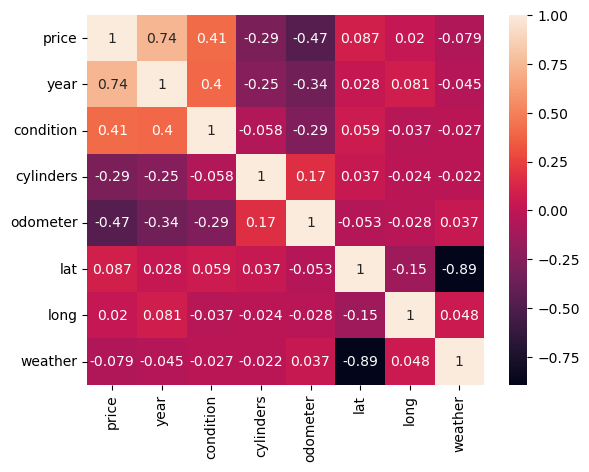

In [20]:
#Проверить признаки на мультиколлинеарность
#импортируем seaborn для построения графиков
import seaborn as sns

# отсеиваем числовые признаки и включаем отображение коэффициентов
sns.heatmap(data.corr(numeric_only=True), annot=True)

Присутствует сильная зависимость между `lat` и `weather`. Удалим `lat`, так как этот признак, в отличие от `weather`, необходимо округлять.

In [21]:
data = data.drop(columns='lat')
data = data.reset_index() #Обновить индексы после удаления нулевых строк

In [22]:
column_ctegor = ['cylinders','condition','title_status','transmission','drive','size']
data[column_ctegor].head()

,cylinders,condition,title_status,transmission,drive,size
0,6,4,clean,automatic,4wd,full-size
1,8,2,clean,automatic,4wd,full-size
2,8,2,clean,automatic,4wd,full-size
3,8,1,rebuilt,automatic,4wd,full-size
4,8,3,clean,automatic,4wd,full-size


In [23]:
#Все категориальные признаки являются номинальными и их не много, поэтому
#Закодируем их с использованием OneHot кодирования
from sklearn.preprocessing import OneHotEncoder
OH_Encoder = OneHotEncoder()

array_OH = OH_Encoder.fit_transform(data[column_ctegor]).toarray()
columns_OH = OH_Encoder.get_feature_names_out(column_ctegor)
data_OH = pd.DataFrame(array_OH, columns=columns_OH)
data_OH.head()

,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8,cylinders_10,condition_0,condition_1,condition_2,condition_3,...,transmission_automatic,transmission_manual,transmission_other,drive_4wd,drive_fwd,drive_rwd,size_compact,size_full-size,size_mid-size,size_sub-compact
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [24]:
#формируем набор данных для обучения модели
data_lr = pd.concat([data,data_OH],axis=1)
data_lr = data_lr.drop(columns=column_ctegor)
data_lr.drop('index',axis=1,inplace=True)
data_lr.head()

,price,year,odometer,long,weather,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8,...,transmission_automatic,transmission_manual,transmission_other,drive_4wd,drive_fwd,drive_rwd,size_compact,size_full-size,size_mid-size,size_sub-compact
0,43900,2016,43500,-82.483400,59.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,15490,2009,98131,-74.281734,52.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2495,2002,201803,-82.949564,45.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1300,2000,170305,-82.349503,49.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,6995,2003,167662,-122.578752,50.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [25]:
#Делим выборку на тренировочные и тестовые данные
y = data_lr['price']
x = data_lr.drop(columns='price')

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=77)

## Обучение модели

In [26]:
model = LinearRegression()
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)

mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

MAE: 4414.982


## Выбор признаков методом рекурсивного исключения признаков

In [27]:
from sklearn.feature_selection import RFE

In [28]:
selector_RFE = RFE(model, n_features_to_select=3, step=1)
selector_RFE.fit(X_train, y_train)

columns_RFE = list(selector_RFE.get_feature_names_out())

In [29]:
columns_RFE

['cylinders_10', 'condition_1', 'condition_5']

In [30]:
#Делим выборку на тренировочные и тестовые данные используя только поля выбранные по методу RFE
y_RFE = data_lr['price']
x_RFE = data_lr[columns_RFE]

X_train_RFE, X_test_RFE, y_train_RFE, y_test_RFE = train_test_split(x_RFE, y_RFE, test_size=0.3, random_state=77)

In [31]:
#Обучаем модель на полях выбранных методом RFE
model_RFE = LinearRegression()
model_RFE.fit(X_train_RFE, y_train_RFE)
y_predicted_RFE = model_RFE.predict(X_test_RFE)

mae_RFE = mean_absolute_error(y_test_RFE, y_predicted_RFE)
print('MAE (RFE): %.3f' % mae_RFE)

MAE (RFE): 8381.858


## ВЫБОР ПРИЗНАКОВ НА ОСНОВЕ ФИЛЬТРОВ

In [32]:
from sklearn.feature_selection import SelectKBest, f_regression

In [33]:
selector_SKB = SelectKBest(f_regression, k=3)
selector_SKB.fit(X_train, y_train)

columns_SKB = list(selector_SKB.get_feature_names_out())

In [34]:
columns_SKB

['year', 'odometer', 'drive_4wd']

In [35]:
#Делим выборку на тренировочные и тестовые данные используя только поля выбранные по методу SKB
y_SKB = data_lr['price']
x_SKB = data_lr[columns_SKB]

X_train_SKB, X_test_SKB, y_train_SKB, y_test_SKB = train_test_split(x_SKB, y_SKB, test_size=0.3, random_state=77)

In [36]:
#Обучаем модель на полях выбранных методом RFE
model_SKB = LinearRegression()
model_SKB.fit(X_train_SKB, y_train_SKB)
y_predicted_SKB = model_SKB.predict(X_test_SKB)

mae_SKB = mean_absolute_error(y_test_SKB, y_predicted_SKB)
print('MAE (SKB): %.3f' % mae_SKB)

MAE (SKB): 4702.187


In [37]:
#Данные для вывода
descr = f'''Абсолютная ошибка МАЕ для всех признаков составила {round(mae,2)}.
для признаков отобранных методом RFE: {round(mae_RFE,2)}:
для признаков отобранных методом SKB: {round(mae_SKB,2)}'''
print(descr)

Абсолютная ошибка МАЕ для всех признаков составила 4414.98.
для признаков отобранных методом RFE: 8381.86:
для признаков отобранных методом SKB: 4702.19


Учитывая, что абсолютная ошибка МАЕ показывает насколько, в среднем, значение цены в предсказании разошлось с реальным  значением можно сделать вывод, что отбор признаков на основе фильтров (SKB) эффективнее чем отбор признаков методом рекурсивного исключения (RFE). 

Данные вывод подтверждается тем, что значение абсолютной ошибки (МАЕ) модели обученной на признаках `SKB` составляет `4702,19`, вто время как модель обученная на признаках отобранных с использованием `RFE` - `8381.86`.

Так же стоит обратить внимание на то, что абсолютная ошибка модели обученой на трех (лучших) показателях отобранных на основе фильтров (SKB) не намного хуже по сравнению с моделью обученной на всех признаках, при этом количество показателей сократилось в 10 раз, с 32 до 3.